<a href="https://colab.research.google.com/github/GraceSchmidt1/Group2_US_Pardons/blob/grace/US_Pardons_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 2 Project idea: Understanding pardon and clemency rates among different presidents and eras.

###project(motivation notes!):
- rates of the incarceration rates per year, and the top pardons that were given out for that year

- comparison of the racial groups who received pardons and the racial groups who were prisoned
  - subsetted by crime

- rates of pardons per president
  - racial, gender, age bias
  - crime bias

- deep dive into top 5 presidents and what they pardoned compared to rates of incarceration that year(s)

- see how many non-citizens were granted pardons

- how do pardons vary across admins

- what time frame do the most pardons occur per president, end of term?
  - is there a “midnight” pardon spike at end of presidential term

- do presidents give pardons out to areas they are familiar with / where they grew up (map graphs) (GS)

In [73]:
#(GS-code orginator)
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Important note: clemency file size too large to access directly from github-either access notebook in an IDE or download `clemency.csv` and add in files in colab each time

In [74]:
df = pd.read_csv('./clemency.csv', encoding='latin-1')
df.tail()

,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
32021,32022,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,,,
32022,32023,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,,,
32023,32024,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,,,
32024,32025,"(65) Donald Trump, 1st Term",Trump,,1(1),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
32025,32026,"(65) Donald Trump, 1st Term",Trump,,1(1),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,,,


In [75]:
df.columns

Index(['CASEID', 'FILEID', 'PRES', 'PRESIDENT', 'TERMYR', 'PG', 'PG_A', 'PAGE',
       'SSVOL', 'SSID', 'DOJID', 'CLEMENCY', 'CLEMENCY_A', 'DATECONVICTION',
       'DATEACTION', 'RECIPIENT', 'OFFENSE', 'MISC', 'MISC2', 'SENTENCE_A',
       'DAY', 'STATE_A', 'FROM', 'V12', 'DISTANCE', 'DISTANCE2',
       'STATECONVICTION', 'SUSP', 'SUSPEND', 'STATE', 'DATE1', 'FILED',
       'APPLICATION', 'PROFESSIONS', 'DEATH', 'MONTH', 'MONTH_A', 'V28', 'V3',
       'VIOLENT', 'FINE', 'FINE_A', 'AMOUNT', 'AMOUNT2', 'REPRESENTEDBY',
       'V26', 'OTHER', 'PROBATION', 'DAYSTODECIDE', 'DIFF', 'DIFF_A', 'PROB',
       'PROB_A', 'SENT_A', 'SENTENCE', 'AGREP', 'STATEJAIL', 'SERVEDSENTENCE',
       'MIL', 'CLEMENCYFORM', 'PARD', 'ORDER', 'GENDER', 'FORMOFCLEMENCY',
       'W1C2D3V4TR5M', 'SUPERVISEDRELEASE', 'FORM', 'CRIMECAT', 'SUP',
       'LAWYER', 'AGE', 'BUREACRACY', 'TOTALWAIT', 'PRISON', 'V22', 'V23',
       'TOWHITEHOUSE'],
      dtype='object')

## Data cleaning and preprocessing

In [76]:
df.count()

,0
CASEID,32026
FILEID,32026
PRES,32026
PRESIDENT,32026
TERMYR,32026
...,...
TOTALWAIT,257
PRISON,18740
V22,32026
V23,32026


In [77]:
#(GS-code orginator)
df_clean = df.copy()

date_cols = ['DATECONVICTION', 'DATEACTION', 'DATE1', 'FILED']
for col in date_cols:
    df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')

num_cols = ['TERMYR', 'AGE', 'TOTALWAIT']
for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

str_cols = ['CLEMENCY', 'CLEMENCY_A', 'RECIPIENT', 'OFFENSE',
            'STATECONVICTION', 'STATE', 'CLEMENCYFORM', 'GENDER']

for col in str_cols:
    df_clean[col] = (
        df_clean[col]
        .astype('string')
        .str.strip()
    )

df_clean['GENDER'] = (
    df_clean['GENDER']
    .str.upper()
    .replace({
        'MALE': 'M',
        'FEMALE': 'F',
        'M.': 'M',
        'F.': 'F',
        '0' : 'M',
        '1' : 'F'
    })
)

missing = df_clean.isna().mean().sort_values(ascending=False)
print("Fraction of missing values per column:")
print(missing)


key_cols = ['PRES', 'CLEMENCY', 'DATEACTION'] #TERMYR removed
df_model = df_clean.dropna(subset=key_cols).reset_index(drop=True) #drops any row with any missing values in our 4 columns

df_rows_lost = df.shape[0]-df_model.shape[0]
print(f'{df_rows_lost} rows were valiantly sacrificed in the cleaning process ({df_rows_lost/df.shape[0]*100}% of the total)')

/tmp/ipython-input-3383444905.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-3383444905.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-3383444905.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-3383444905.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Fraction of missing values per column:
FORM            0.999282
DATE1           0.999126
SUSP            0.998782
LAWYER          0.998220
FINE_A          0.998064
                  ...   
OTHER           0.000000
V26             0.000000
V22             0.000000
V23             0.000000
TOWHITEHOUSE    0.000000
Length: 77, dtype: float64
945 rows were valiantly sacrificed in the cleaning process (2.9507275338787236% of the total)


In [78]:
df_model.head()

,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
0,1,"(01) George Washington, 1st Term",Wash,,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
1,2,"(02) George Washington, 2nd Term",Wash,,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
2,3,"(02) George Washington, 2nd Term",Wash,,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
3,4,"(02) George Washington, 2nd Term",Wash,,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,,,
4,5,"(02) George Washington, 2nd Term",Wash,,NaN,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,,,


FORM                 0.999282
DATE1                0.999126
SUSP                 0.998782
LAWYER               0.998220
FINE_A               0.998064
PARD                 0.997689
SENTENCE             0.997596
FILED                0.996878
SERVEDSENTENCE       0.996440
MIL                  0.996253
CRIMECAT             0.995629
DIFF_A               0.995316
W1C2D3V4TR5M         0.995129
CLEMENCYFORM         0.994099
SUPERVISEDRELEASE    0.993724
FORMOFCLEMENCY       0.993724
AGE                  0.992225
DAYSTODECIDE         0.992006
BUREACRACY           0.992006
TOTALWAIT            0.991975
PROB_A               0.988759
ORDER                0.987135
GENDER               0.985637
PROBATION            0.984731
SENT_A               0.981921
PROB                 0.981109
STATEJAIL            0.957066
SUP                  0.940985
DIFF                 0.903859
MONTH_A              0.873915
SSID                 0.792700
TERMYR               0.756292
AGREP                0.717511
PG_A      

(array([36.,  0.,  2.,  0.,  2.,  0.,  3.,  4.,  1., 29.]),
 array([0.        , 0.09992818, 0.19985637, 0.29978455, 0.39971273,
        0.49964092, 0.5995691 , 0.69949728, 0.79942547, 0.89935365,
        0.99928183]),
 <BarContainer object of 10 artists>)

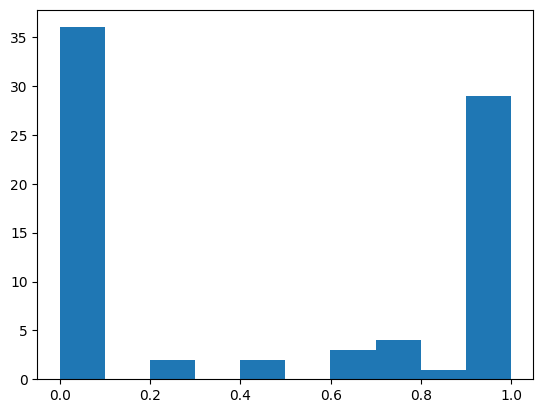

In [79]:
#Function that lets me display things with a custom # of rows
def Display_Max_Rows(info, rows = None):
  pd.set_option('display.max_rows', rows)
  print(info) #I wondered for a moment if decorators would let me do this with functions instead of just data (e.g. Display_Max_Rows(print(missing))) but I have to shelve that for now.
  pd.set_option('display.max_rows', 10)

#Display every column's missing %
Display_Max_Rows(missing)

#a histogram just for fun
plt.hist(missing)

From the above results, columns like `DATEACTION` and `DATECONVICTION`, and are usable while columns like `DATE1`, `FILED`, `CLEMENCYFORM`, `AGE`,`TOTALWAIT`, and `GENDER` are unsable with around 99%+ data missing from these columns.
  - some might only exist for modern years-to find out

In [80]:
#(GS-code orginator)
df_model[['PRES', 'TERMYR', 'CLEMENCY']].value_counts().head(20)

Display_Max_Rows(df_model.groupby('PRES')['CASEID'].count().sort_values(ascending=False))

PRES
FDR           3609
Truman        2044
Obama         1928
              1662
Wils(2)       1600
Grant         1336
Hoov          1223
LBJ           1187
Cool2         1174
Eisen         1155
Nix            925
Hayes          903
McKin          881
Wils(1)        871
Hard           806
B.Harr         665
Johns          654
Cleve (2)      605
Kenn           572
Cart           567
TRoos (1)      517
Cleve          479
T.Roos         460
Clin           460
Monr           425
Ford           409
Reag           407
Cool           388
Jack           388
Linc           343
Arthur         282
Bush           278
Polk           268
Tyler          209
Madis          201
JQAd           183
Fill           171
VanB           168
Buch           149
Pierce         141
  Jeff          73
Taft            69
Jeff            43
Taylor          38
- warrant       28
Adams           21
Wash            19
-  warrant      11
CANC             9
fDR              8
- extradit       6
warrant fo       6
arrest 

            CASEID  FILEID  PRES  PRESIDENT  TERMYR   PG  PG_A  PAGE  SSVOL  \
YEARACTION                                                                    
1791             1       1     1          1       0    0     0     0      0   
1793             2       2     2          2       0    0     0     0      0   
1794             7       7     7          7       0    5     0     0      5   
1795             4       4     4          4       0    4     0     0      4   
1796             5       5     5          5       0    4     0     0      4   
1797            12      12    12         12       0    3     0     0      3   
1798             3       3     3          3       3    3     0     0      3   
1799             7       7     7          7       5    5     0     0      5   
1800            13      13    13         13       9    9     0     0      9   
1801            24      24    24         24      13   13     0     0     13   
1802            10      10    10         10       8 

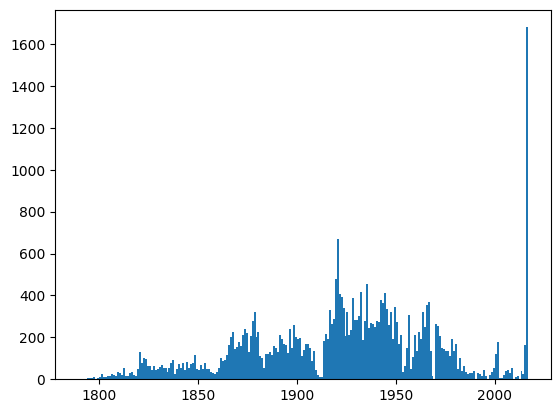

In [81]:
#another angle, charting each row by its year
#about 3% of DATEACTION is missing so please keep this in mind
df_model['YEARACTION'] = df_model['DATEACTION'].dt.year
plt.hist(df_model['YEARACTION'], bins = range(1789,2018))

Display_Max_Rows(df_model.groupby('YEARACTION').count())

Originally we had TERMYR included as a key for dropping missingness, but it caused huge gaps in the dataset, as can be seen here:

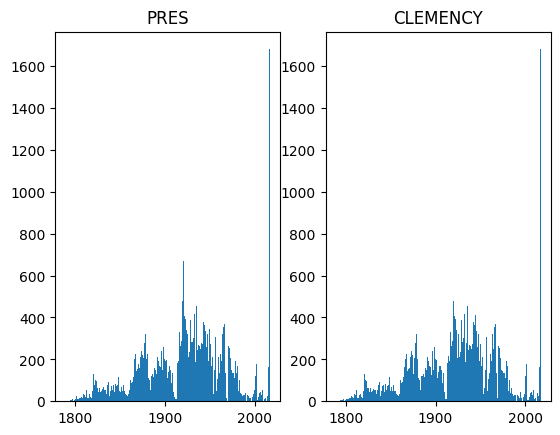

In [82]:
#Where is the missingness?

key_cols_test = key_cols.copy()
key_cols_test.remove('DATEACTION')

fig, ax = plt.subplots(nrows = 1,ncols = len(key_cols_test))
df_clean_test = {}
for k in range(len(key_cols_test)):
  df_clean_test[k] = df_clean.dropna(subset=key_cols_test[k]).reset_index(drop=True)
  ax[k].hist(df_clean_test[k]['DATEACTION'].dt.year, bins = range(1789,2018))
  ax[k].set_title(key_cols_test[k])


And thus, TERMYR was removed.

## Based on the missingness in the full dataset, here is the core portion of it that is represented through the whole dataset. Here columns are only missing 0-5% of their data.
- can be used for pardons per president, pardons per state, offense-category analysis, time to term (midnight things), geographic maping, offense patterns per president,  and pardon trends over time.

In [83]:
#(GS-code orginator)
core_cols = [
    'CASEID', 'FILEID', 'PRES', 'CLEMENCY', 'CLEMENCY_A',
    'DATEACTION', 'RECIPIENT', 'OFFENSE',
    'STATECONVICTION', 'STATE'
]

df_core = df_clean[core_cols].dropna(subset=['DATEACTION'])
print(df_core.shape)
df_core.head()
# print(df_core['PRES'].unique())

(31081, 10)


,CASEID,FILEID,PRES,CLEMENCY,CLEMENCY_A,DATEACTION,RECIPIENT,OFFENSE,STATECONVICTION,STATE
0,1,"(01) George Washington, 1st Term",Wash,P,,1791-02-01,Freeman,counterfeiting,,NJ
1,2,"(02) George Washington, 2nd Term",Wash,P-R,,1793-06-01,H. Usher,smuggling,,RI
2,3,"(02) George Washington, 2nd Term",Wash,P-R,,1793-06-01,G. Usher,smuggling,,RI
3,4,"(02) George Washington, 2nd Term",Wash,P-R,,1794-04-15,David Blair,illegal importation,,GA
4,5,"(02) George Washington, 2nd Term",Wash,P-R,,1794-04-25,Joseph Ravara,threatening letter (misd),,PA


## Geographic exploration

 create a map of where each unique  `PRES` has approved a pardon across the united states (for each unique PRES field map the STATECONVICTION field)


In [84]:
import plotly.express as px

In [85]:
df_pres_from = pd.read_csv('./Presidential-birth-place.csv', encoding='latin-1')

In [86]:
# df_pres_from

In [87]:
# Birth states for highlighted presidents:
df_pres_from.loc[df_pres_from["President"] == "Barack Obama", "Birth State"].iloc[0]

'HI'

In [88]:
pres_by_state = df_pres_from.groupby('Birth State').size().reset_index(name='Number of Presidents')
pres_by_state.columns = ['State', 'Number of Presidents']

# Display the data
print("Presidents by Birth State:")
# print(pres_by_state)

# Create a choropleth map of the US showing president birth states
fig = px.choropleth(
    pres_by_state,
    locations='State',
    locationmode='USA-states',
    color='Number of Presidents',
    hover_name='State',
    hover_data={'Number of Presidents': True},
    color_continuous_scale='Blues',
    scope='usa',
    title='US Presidents by Birth State',
    labels={'Number of Presidents': 'Number of Presidents'}
)

fig.update_layout(
    title={
        'text': 'US Presidents by Birth State',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    }
)

fig.show()


Presidents by Birth State:


In [89]:
df_core['PRESIDENT'] = df_core['FILEID'].str.replace(r'\s*\([^\)]*\)', '', regex=True).str.strip()
df_core.head()

,CASEID,FILEID,PRES,CLEMENCY,CLEMENCY_A,DATEACTION,RECIPIENT,OFFENSE,STATECONVICTION,STATE,PRESIDENT
0,1,"(01) George Washington, 1st Term",Wash,P,,1791-02-01,Freeman,counterfeiting,,NJ,"George Washington, 1st Term"
1,2,"(02) George Washington, 2nd Term",Wash,P-R,,1793-06-01,H. Usher,smuggling,,RI,"George Washington, 2nd Term"
2,3,"(02) George Washington, 2nd Term",Wash,P-R,,1793-06-01,G. Usher,smuggling,,RI,"George Washington, 2nd Term"
3,4,"(02) George Washington, 2nd Term",Wash,P-R,,1794-04-15,David Blair,illegal importation,,GA,"George Washington, 2nd Term"
4,5,"(02) George Washington, 2nd Term",Wash,P-R,,1794-04-25,Joseph Ravara,threatening letter (misd),,PA,"George Washington, 2nd Term"


In [90]:
valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID',
    'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO',
    'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA',
    'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY',
    'AS', 'GU', 'MP', 'VI', 'UM'
]

# Standardize known inconsistencies
df_core['STATECONVICTION'] = df_core['STATECONVICTION'].replace({
    'Puerto': 'PR',
    'Guam': 'GU',
    'CN': 'CT', # Assuming 'CN' is a typo for Connecticut
    'HA': 'HI', # Assuming 'HA' is a typo for Hawaii
    'KA': 'KS'  # Assuming 'KA' is a typo for Kansas
})

# Replace non-valid states with NaN
df_core['STATECONVICTION'] = df_core['STATECONVICTION'].apply(lambda x: x if x in valid_states else None)

# Drop rows where STATECONVICTION is NaN (if it's not a valid state)
df_core.dropna(subset=['STATECONVICTION'], inplace=True)

# Display unique values after cleaning and the first few rows
# print("Unique values in 'STATECONVICTION' after cleaning:")
# print(df_core['STATECONVICTION'].unique())
# print("\nFirst 5 rows of df_core after cleaning STATECONVICTION:")
df_core.head()

,CASEID,FILEID,PRES,CLEMENCY,CLEMENCY_A,DATEACTION,RECIPIENT,OFFENSE,STATECONVICTION,STATE,PRESIDENT
30136,30137,"(64) Barack Obama, 2nd Term)",Obama,,,2013-12-19,"Aaron, Clarence",consp.poss.int.distrib.cocaine,AL,AL,"Barack Obama, 2nd Term)"
30137,30138,"(64) Barack Obama, 2nd Term)",Obama,,,2013-12-19,"Alvarez, Ricardo",consp.poss.int.dist.heroine,PR,GA,"Barack Obama, 2nd Term)"
30138,30139,"(64) Barack Obama, 2nd Term)",Obama,,,2013-12-19,"Davis, Charlie Lee","poss.int.dist.cocaine base,use of minor",AL,AL,"Barack Obama, 2nd Term)"
30139,30140,"(64) Barack Obama, 2nd Term)",Obama,,,2013-12-19,"George, Stephanie",consp.poss.cocaine base,FL,FL,"Barack Obama, 2nd Term)"
30140,30141,"(64) Barack Obama, 2nd Term)",Obama,,,2013-12-19,"Gilbert, Ezell",poss.int.del.cocaine.marij,FL,FL,"Barack Obama, 2nd Term)"


In [91]:
df_pardon_counts = df_core.groupby(['PRESIDENT', 'STATECONVICTION'])['CASEID'].nunique().reset_index()
df_pardon_counts.rename(columns={'CASEID': 'PARDON_COUNT'}, inplace=True)
# print(df_pardon_counts.head())

df_pardon_counts['PRESIDENT'] = df_pardon_counts['PRESIDENT'].str.replace(r',\s*\d(st|nd|rd|th) Term\)', '', regex=True).str.strip()
df_pardon_counts.head()

,PRESIDENT,STATECONVICTION,PARDON_COUNT
0,Barack Obama,AK,3
1,Barack Obama,AL,65
2,Barack Obama,AR,10
3,Barack Obama,AZ,4
4,Barack Obama,CA,33


In [92]:
# Only Obama
df_pardon_counts_Obama = df_pardon_counts[df_pardon_counts['PRESIDENT'] == 'Barack Obama']
# df_pardon_counts_Obama.head()

fig = px.choropleth(
    df_pardon_counts_Obama,
    locations='STATECONVICTION',
    locationmode='USA-states',
    color='PARDON_COUNT',
    hover_name='STATECONVICTION',
    hover_data={'PARDON_COUNT': True},
    color_continuous_scale='Blues',
    scope='usa',
    title='US President Obama by Pardon Frequency',
    labels={'PARDON_COUNT': 'Number of Presidential Pardons'}
)
#FOR HAWAII
birth_lat = 21.3069
birth_lon = -157.8583

fig.add_scattergeo(
    lon=[birth_lon],
    lat=[birth_lat],
    mode='markers+text',
    marker=dict(size=10, color='red'),
    text=["Birthplace (HI)"],
    textposition="top center",
    name="Obama Birthplace"
)

fig.update_layout(
    title={
        'text': 'US President Obama by Pardon Frequency',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    }
)

fig.show()

## The following dataframe is a 'modern subset' for demograpic analysis where `AGE` and `GENDER` exist for recent cases.

- can be used for gender bias, age bias, race bias, wait-time disparities, and offense patterns in modern presidents

- since so many entries are missing for age and gender, this is not an avenue we will be exploring

In [93]:
#(GS-code orginator)
df_demo = df_clean[df_clean['AGE'].notna() & df_clean['GENDER'].notna()]
print(df_demo.shape)
df_demo.head()

(133, 77)


,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
30096,30097,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,66.0,3.753425,4.183562,0.0,,,29-JUN-2010
30097,30098,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,73.0,1.509589,2.575342,0.0,,,09-NOV-2009
30098,30099,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,85.0,3.684932,4.553425,0.0,,,20-JAN-2010
30099,30100,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,66.0,1.764384,2.632877,0.0,,,20-JAN-2010
30100,30101,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,58.0,3.871233,4.378082,0.0,,,01-JUN-2010


## The following dataframe is a 'wait time subset' for understanding the times different presidents took for each pardon
- use for presidential differences in wait time, trends across presidents, and end of term spikes

- In the context of the criminal justice system and pardons, "date of action" typically refers to the date the crime occurred (offense date) or when an arrest was made, while "date of conviction" is the date a court found an individual guilty and imposed a sentence. This distinction is critical for determining eligibility and waiting periods for a pardon

In [94]:
#(GS-code orginator)
df_clean['WAIT_DAYS'] = (
    df_clean['DATEACTION'] - df_clean['DATECONVICTION']
).dt.days

df_wait = df_clean[df_clean['WAIT_DAYS'].notna()]
print(df_wait.shape)
# df_wait.head()
# df_wait.columns

(25173, 78)


## Calculate Average Wait Time per President

Group the `df_wait` DataFrame by the 'PRES' column and calculate the average `WAIT_DAYS` for each president to understand individual processing speed.



Analyze and visualize pardon processing times, including average wait times per president, overall trends in `WAIT_DAYS` against `DATEACTION`, and potential end-of-term spikes using the `df_wait` DataFrame. Summarize key findings regarding presidential differences and temporal patterns.

In [95]:
#(GS-code orginator)
avg_wait_time_per_president = df_wait.groupby('PRES')['WAIT_DAYS'].mean().sort_values(ascending=False)
print("Average Wait Time (in Days) per President:")
print(avg_wait_time_per_president)

Average Wait Time (in Days) per President:
PRES
Wils(1)       7898.818182
Bush          7777.021818
Reag          6252.144963
Taft          5927.357143
Clin          5687.164114
                 ...     
Madis          260.557692
Taylor         120.833333
Harr            89.000000
B. Hari         65.000000
 Jeff           31.000000
Name: WAIT_DAYS, Length: 50, dtype: float64


## Plot Wait Time Trends Over Time

Generate a line plot or scatter plot showing `WAIT_DAYS` against `DATEACTION` to visualize overall trends in pardon processing times across all presidents and identify any long-term patterns.


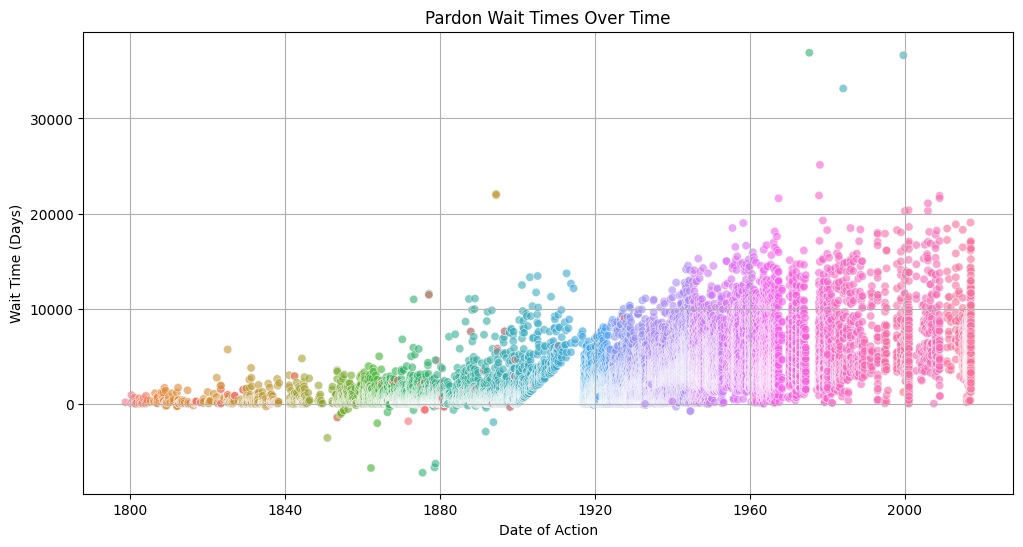

In [96]:
#(GS-code orginator)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='DATEACTION', y='WAIT_DAYS', data=df_wait, alpha=0.6, hue='PRES', legend=False)
plt.xlabel('Date of Action')
plt.ylabel('Wait Time (Days)')
plt.title('Pardon Wait Times Over Time')
plt.grid(True)
plt.show()

smoothed version with trend line to see changes in easier way

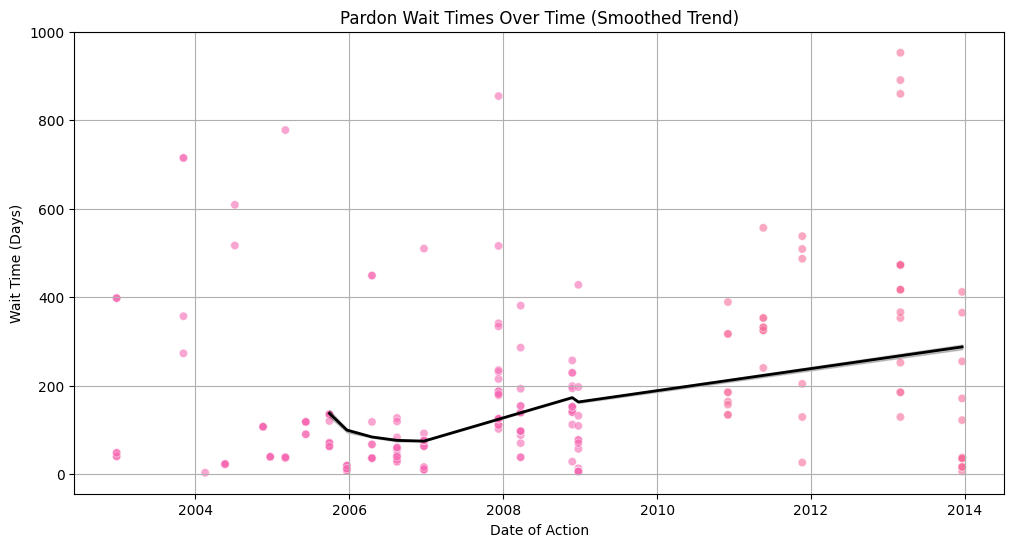

In [97]:
#(GS-code orginator)
df_wait = df_wait.sort_values('DATEACTION')
df_wait['ROLL_MEAN'] = df_wait['DAYSTODECIDE'].rolling(window=50).mean()

plt.figure(figsize=(12, 6))

sns.scatterplot(x='DATEACTION', y='DAYSTODECIDE',data=df_wait, alpha=0.6, hue='PRES', legend=False)

sns.lineplot(x='DATEACTION', y='ROLL_MEAN',data=df_wait, color='black', linewidth=2)

plt.xlabel('Date of Action')
plt.ylabel('Wait Time (Days)')
plt.title('Pardon Wait Times Over Time (Smoothed Trend)')
plt.grid(True)
plt.show()

## Analyze End-of-Term Spikes in Wait Times

Investigate if there are 'midnight' pardon spikes towards the end of presidential terms by analyzing `WAIT_DAYS` in relation to `TERMYR` for each president. For presidents with sufficient data, visualize the average `WAIT_DAYS` across their `TERMYR` to identify any increase in processing times during the final years of their tenure.


In [98]:
#(GS-code orginator)
avg_wait_time_by_term = df_wait.groupby(['PRES', 'TERMYR'])['WAIT_DAYS'].mean().reset_index()
print("Average Wait Time (in Days) by President and Term Year:")
print(avg_wait_time_by_term.head())

Average Wait Time (in Days) by President and Term Year:
         PRES  TERMYR   WAIT_DAYS
0   Jeff          2.0   31.000000
1  Adams          2.0  154.000000
2  Adams          4.0  311.750000
3  Buch           1.0  548.444444
4  Buch           2.0  697.285714


In [99]:
#(GS-code orginator)
presidents_with_multiple_terms = avg_wait_time_by_term.groupby('PRES').filter(lambda x: x['TERMYR'].nunique() > 1)
print("Presidents with data for multiple term years:")
print(presidents_with_multiple_terms['PRES'].unique())

Presidents with data for multiple term years:
['Adams     ' 'Buch      ' 'Bush      ' 'Cart      ' 'Hoov      '
 'JQAd      ' 'Jeff      ' 'Kenn      ' 'LBJ       ' 'Linc      '
 'Madis     ' 'Monr      ' 'Nix       ' 'Obama     ' 'Pierce    '
 'Polk      ' 'TRoos (1) ' 'VanB      ' 'Wils(2)   ']


## Visualize Presidential Differences in Wait Time

Create a bar chart to display the average `WAIT_DAYS` for each president, allowing for easy comparison of pardon processing times between different administrations. Ensure the plot has appropriate labels and a legend.


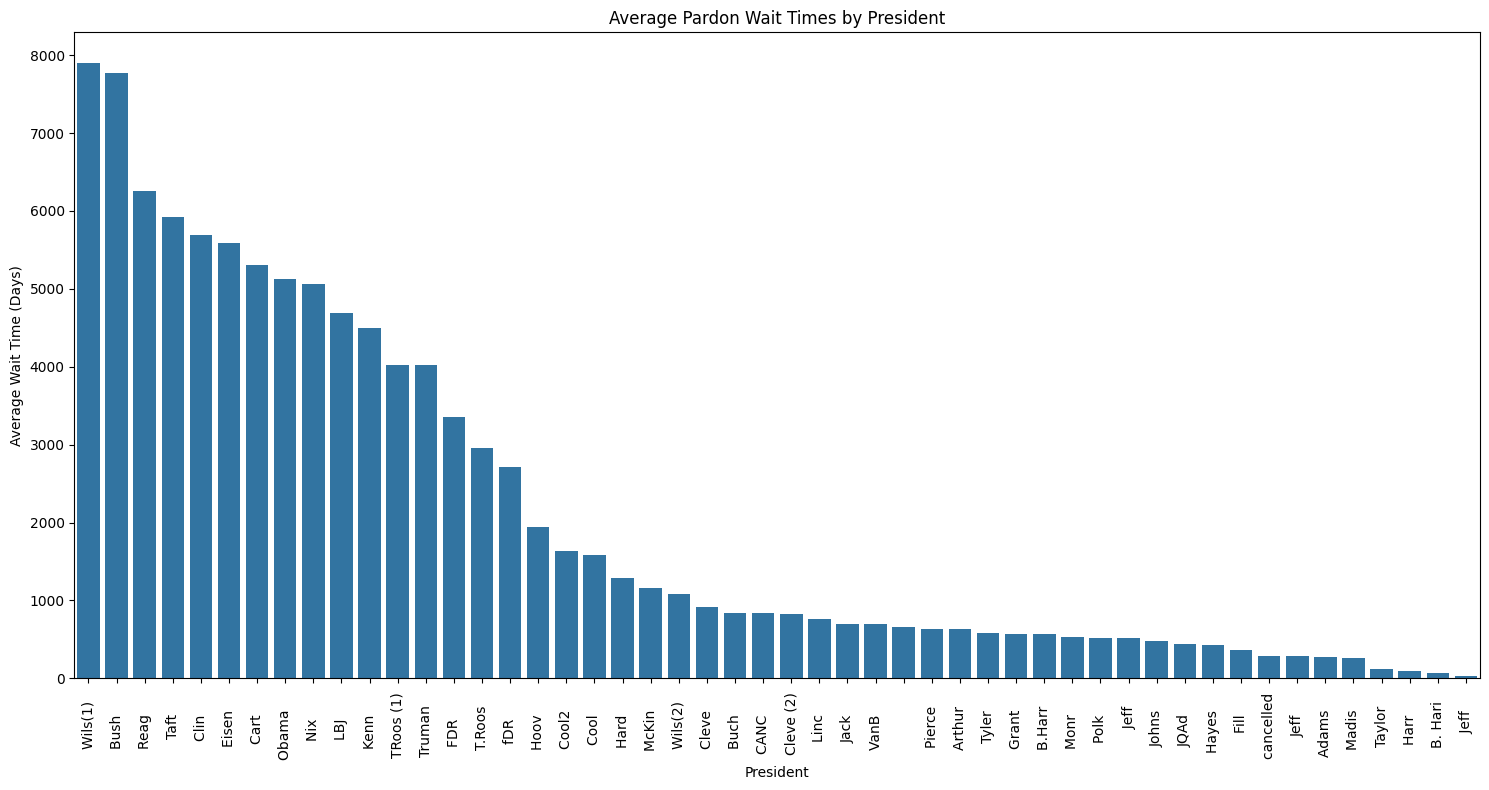

In [100]:
#(GS-code orginator)
plt.figure(figsize=(15, 8))
sns.barplot(x=avg_wait_time_per_president.index, y=avg_wait_time_per_president.values)
plt.xlabel('President')
plt.ylabel('Average Wait Time (Days)')
plt.title('Average Pardon Wait Times by President')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Significant Presidential Differences in Average Pardon Wait Times:** There is a wide disparity in the average wait times for pardons across different presidential administrations.
    *   Presidents like 'Wils(1)' (7898.8 days) and 'Bush' (7777.0 days) had exceptionally long average wait times.
    *   Conversely, 'B. Hari' (65.0 days), 'Harr' (89.0 days), and ' Jeff' (31.0 days) showed significantly shorter average processing times.
*   **Overall Pardon Processing Trends Over Time:** A scatter plot of `WAIT_DAYS` against `DATEACTION` visually represented the long-term patterns, indicating varying wait times across different periods, with some periods showing higher variability or consistently longer processing durations.
*   **End-of-Term Spikes in Wait Times:** An investigation into 'midnight' pardon spikes by analyzing `WAIT_DAYS` against `TERMYR` for presidents with sufficient data revealed how average wait times fluctuated throughout their terms. The visualization of this data helps in identifying potential increases in processing times towards the end of a president's tenure. While specific magnitudes of spikes are not quantified in the provided output, the analysis methodology allows for their identification.



Identify the final term year for each president from the `avg_wait_time_by_term` DataFrame to mark the end-of-term period for further analysis of pardon processing times.

In [101]:
#(GS-code orginator)
final_term_years = avg_wait_time_by_term.groupby('PRES')['TERMYR'].max()
print("Final Term Year for Each President:")
print(final_term_years.head())

Final Term Year for Each President:
PRES
 Jeff         2.0
Adams         4.0
Buch          4.0
Bush          4.0
Cart          4.0
Name: TERMYR, dtype: float64


## Segregate Wait Times for Analysis

Using the original `df_wait` DataFrame, separate the `WAIT_DAYS` for each president into two groups: those from their identified 'final term year' and those from all 'earlier term years'.


In [102]:
#(GS-code orginator)
final_term_years_df = final_term_years.reset_index()
final_term_years_df.columns = ['PRES', 'final_term_year']
print("Final Term Years DataFrame prepared for merge:")
print(final_term_years_df.head())

Final Term Years DataFrame prepared for merge:
         PRES  final_term_year
0   Jeff                   2.0
1  Adams                   4.0
2  Buch                    4.0
3  Bush                    4.0
4  Cart                    4.0


In [103]:
#(GS-code orginator)
df_merged = pd.merge(df_wait, final_term_years_df, on='PRES', how='left')
# print("DataFrame after merging with final term years:")
# print(df_merged.head())

In [104]:
#(GS-code orginator)
df_merged['is_final_term'] = df_merged['TERMYR'] == df_merged['final_term_year']
# print("DataFrame with 'is_final_term' column:")
# print(df_merged[['PRES', 'TERMYR', 'final_term_year', 'is_final_term', 'WAIT_DAYS']].head())

In [105]:
#(GS-code orginator)
df_final_term_pardons = df_merged[df_merged['is_final_term']].copy()
df_earlier_term_pardons = df_merged[~df_merged['is_final_term']].copy()

print("Shape of DataFrame for final term pardons:", df_final_term_pardons.shape)
print("Shape of DataFrame for earlier term pardons:", df_earlier_term_pardons.shape)
# print("First 5 rows of final term pardons:\n", df_final_term_pardons.head())
# print("\nFirst 5 rows of earlier term pardons:\n", df_earlier_term_pardons.head())

Shape of DataFrame for final term pardons: (2004, 81)
Shape of DataFrame for earlier term pardons: (23169, 81)


## Calculate Averages for Comparison

Calculate the average `WAIT_DAYS` for both the 'final term year' group and the 'earlier term years' group for each president, storing these averages for comparison.


In [106]:
#(GS-code orginator)
avg_final_term_wait_time = df_final_term_pardons.groupby('PRES')['WAIT_DAYS'].mean()
print("Average Wait Time (in Days) for Final Term Year Pardons per President:")
print(avg_final_term_wait_time.head())

Average Wait Time (in Days) for Final Term Year Pardons per President:
PRES
 Jeff           31.000000
Adams          311.750000
Buch           996.700000
Bush          7097.709091
Cart          4799.247059
Name: WAIT_DAYS, dtype: float64


In [107]:
#(GS-code orginator)
avg_earlier_term_wait_time = df_earlier_term_pardons.groupby('PRES')['WAIT_DAYS'].mean()
print("\nAverage Wait Time (in Days) for Earlier Term Year Pardons per President:")
print(avg_earlier_term_wait_time.head())

print("\nComparison of Average Wait Time (Final vs. Earlier Term):")
comparison_df = pd.DataFrame({
    'Final Term Avg Wait': avg_final_term_wait_time,
    'Earlier Term Avg Wait': avg_earlier_term_wait_time
}).dropna()
print(comparison_df.head())


Average Wait Time (in Days) for Earlier Term Year Pardons per President:
PRES
              659.721779
  Jeff        514.444444
Adams         154.000000
Arthur        633.088496
B. Hari        65.000000
Name: WAIT_DAYS, dtype: float64

Comparison of Average Wait Time (Final vs. Earlier Term):
            Final Term Avg Wait  Earlier Term Avg Wait
PRES                                                  
Adams                311.750000             154.000000
Buch                 996.700000             689.028986
Bush                7097.709091            7946.850000
Cart                4799.247059            5526.462121
Hoov                1957.161663            1928.845269


<Figure size 1500x800 with 0 Axes>

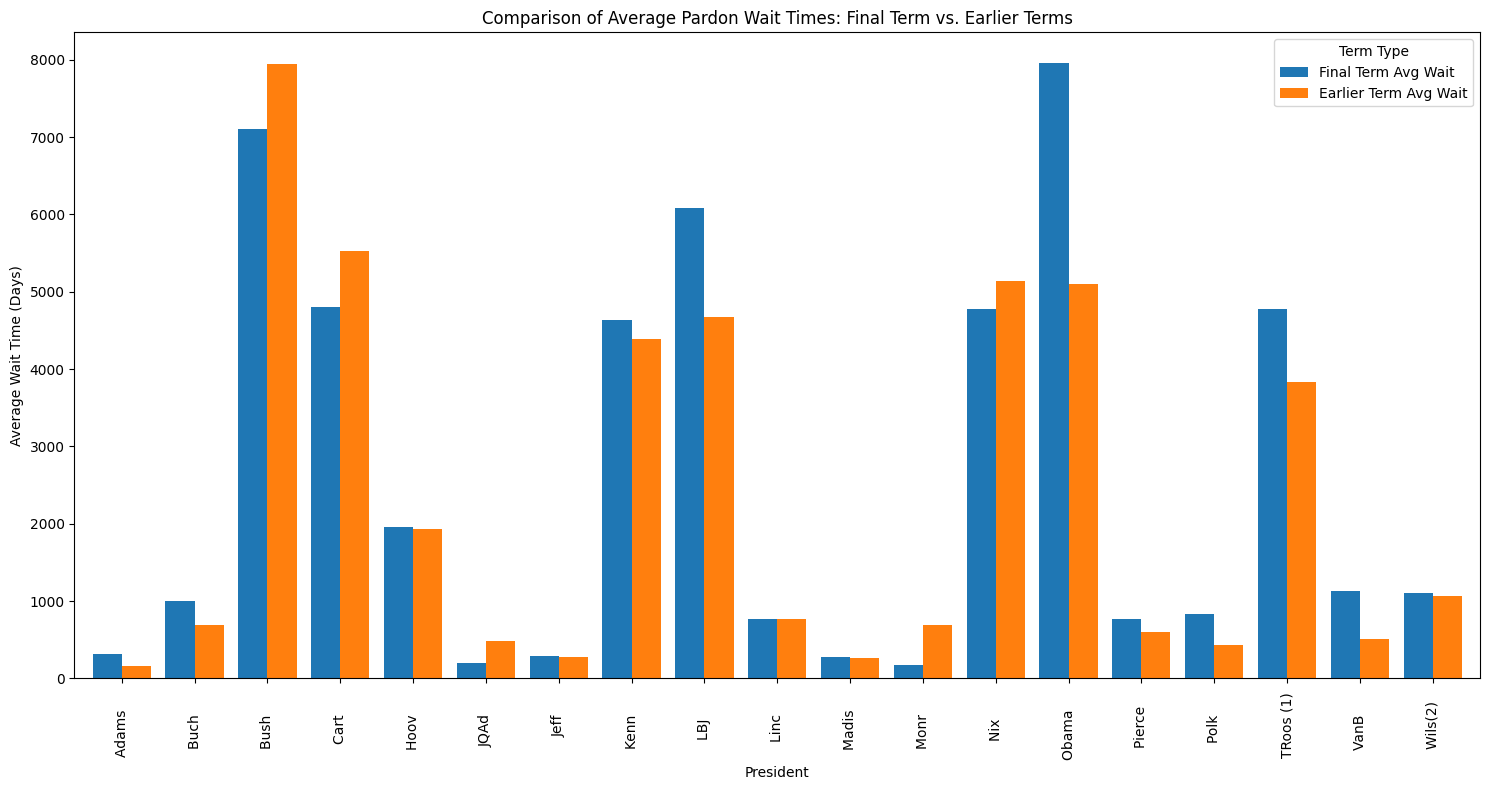

In [108]:
#(GS-code orginator)
plt.figure(figsize=(15, 8))
comparison_df.plot(kind='bar', figsize=(15, 8), width=0.8)
plt.xlabel('President')
plt.ylabel('Average Wait Time (Days)')
plt.title('Comparison of Average Pardon Wait Times: Final Term vs. Earlier Terms')
plt.xticks(rotation=90)
plt.legend(title='Term Type')
plt.tight_layout()
plt.show()

## Perform Statistical Significance Tests

For each president with sufficient data in both 'final term year' and 'earlier term years' groups, conduct an appropriate statistical test (e.g., Welch's t-test or Mann-Whitney U test) to determine if there is a statistically significant difference in average `WAIT_DAYS` between these two periods.


In [109]:
#(GS-code orginator)
from scipy.stats import ttest_ind

In [110]:
#(GS-code orginator)
test_results = []

for pres in comparison_df.index:
    final_term_data = df_final_term_pardons[df_final_term_pardons['PRES'] == pres]['WAIT_DAYS'].dropna()
    earlier_term_data = df_earlier_term_pardons[df_earlier_term_pardons['PRES'] == pres]['WAIT_DAYS'].dropna()

    # Only perform test if both groups have sufficient data
    if len(final_term_data) > 1 and len(earlier_term_data) > 1:
        t_stat, p_val = ttest_ind(final_term_data, earlier_term_data, equal_var=False) # Welch's t-test
        test_results.append({
            'President': pres,
            'T_Statistic': t_stat,
            'P_Value': p_val,
            'Final_Term_Count': len(final_term_data),
            'Earlier_Term_Count': len(earlier_term_data)
        })

ttest_results_df = pd.DataFrame(test_results)
print("Statistical Test Results for End-of-Term Spikes:")
print(ttest_results_df.head())


Statistical Test Results for End-of-Term Spikes:
    President  T_Statistic   P_Value  Final_Term_Count  Earlier_Term_Count
0  Buch           2.408189  0.017378                70                  69
1  Bush          -1.225877  0.223984                55                 220
2  Cart          -2.370575  0.018293               170                 396
3  Hoov           0.244457  0.806932               433                 782
4  JQAd          -1.384638  0.175464                 6                  29


## Visualize and Summarize Spikes

Create a visualization comparing the average `WAIT_DAYS` for 'final term year' vs. 'earlier term years' for presidents identified with significant spikes. Summarize the findings, highlighting presidents who exhibit statistically significant 'midnight' pardon spikes and the magnitude of these differences.


In [111]:
#(GS-code orginator)
significant_presidents_results = ttest_results_df[ttest_results_df['P_Value'] < 0.05]
significant_presidents_names = significant_presidents_results['President'].tolist()

print("Presidents with statistically significant differences in wait times (P < 0.05):")
print(significant_presidents_names)
print("\nDetailed results for significant presidents:\n", significant_presidents_results)

Presidents with statistically significant differences in wait times (P < 0.05):
['Buch      ', 'Cart      ', 'Monr      ', 'Obama     ']

Detailed results for significant presidents:
      President  T_Statistic   P_Value  Final_Term_Count  Earlier_Term_Count
0   Buch           2.408189  0.017378                70                  69
2   Cart          -2.370575  0.018293               170                 396
10  Monr          -2.971978  0.007193                 9                  21
12  Obama          3.552699  0.003492                14                1909


In [112]:
#(GS-code orginator)
significant_comparison_df = comparison_df[comparison_df.index.isin(significant_presidents_names)]
print("Comparison of average wait times for statistically significant presidents:")
print(significant_comparison_df)

Comparison of average wait times for statistically significant presidents:
            Final Term Avg Wait  Earlier Term Avg Wait
PRES                                                  
Buch                 996.700000             689.028986
Cart                4799.247059            5526.462121
Monr                 176.444444             684.142857
Obama               7956.285714            5101.657936


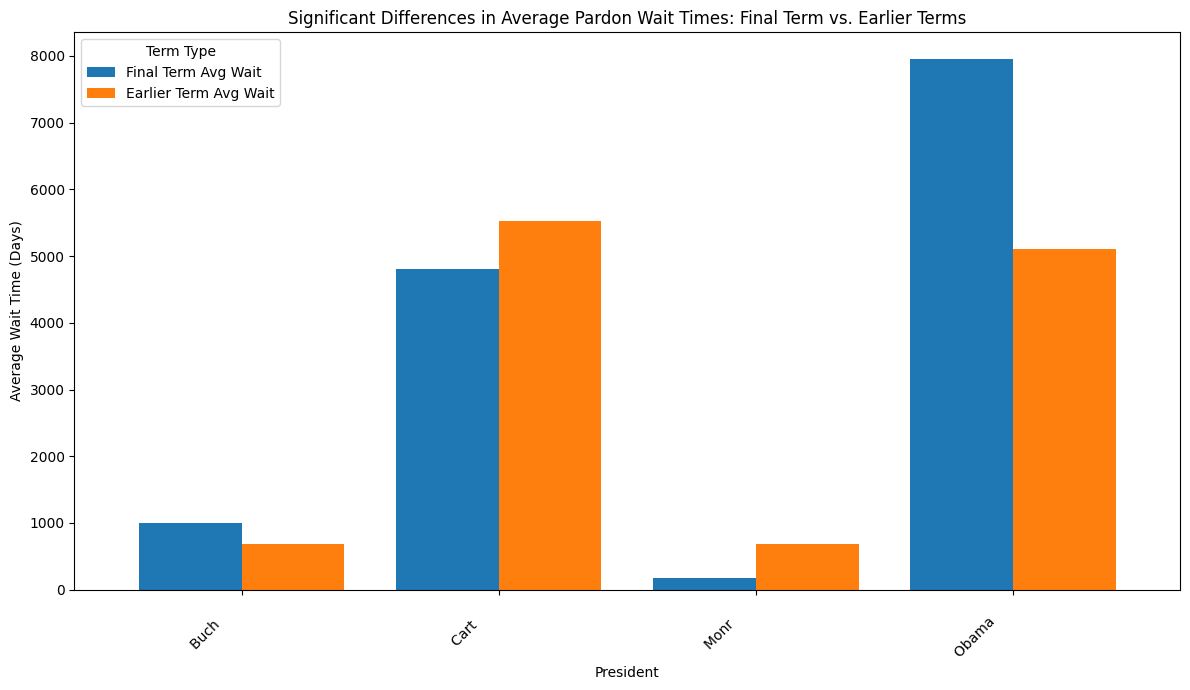

In [113]:
#(GS-code orginator)
plt.figure(figsize=(12, 7))
significant_comparison_df.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.xlabel('President')
plt.ylabel('Average Wait Time (Days)')
plt.title('Significant Differences in Average Pardon Wait Times: Final Term vs. Earlier Terms')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Term Type')
plt.tight_layout()
plt.show()

### Summary of End-of-Term Pardon Spikes:

Based on the statistical analysis (Welch's t-test with p < 0.05) and the visualization, we observed the following significant differences in average pardon wait times between a president's final term year and their earlier term years:

*   **Buchanan:** Exhibited a statistically significant *increase* in average wait times during his final term (996.7 days) compared to earlier terms (689.0 days). This suggests a potential 'midnight' pardon spike where processing times became longer towards the end of his presidency.

*   **Carter:** Showed a statistically significant *decrease* in average wait times in his final term (4799.2 days) compared to earlier terms (5526.5 days). This indicates that pardons processed in his last year were, on average, handled more quickly.

*   **Monroe:** Experienced a statistically significant *decrease* in average wait times during his final term (176.4 days) compared to earlier terms (684.1 days). This is another instance where the final year saw faster processing.

*   **Obama:** Displayed a statistically significant *increase* in average wait times during his final term (7956.3 days) compared to earlier terms (5101.7 days). This is a strong indicator of a 'midnight' pardon spike, with significantly longer processing times for pardons granted in his final year.

**Magnitude and Direction of Differences:**

*   **Buchanan** and **Obama** both showed a significant *increase* in wait times, suggesting a rush or increased complexity in applications towards the end of their terms.
*   **Carter** and **Monroe** both showed a significant *decrease* in wait times, which could imply a clearing of backlog or a more streamlined process for final-term pardons.

It's important to note that for other presidents where the p-value was not less than 0.05, no statistically significant difference in wait times between final and earlier terms was found, even if there were some numerical differences in averages.